# Knowledge Distillation

## (In progress)

---

I recently read [Distilling the Knowledge in a Neural Network](https://arxiv.org/pdf/1503.02531) and wanted to try out two MNIST experiments:

1) Train a model on a subset of the data using soft targets
    - for example, train a large model on 100% of the data
    - use the large predictions as soft targets for a small model trained on 10% of the data

2) Train a small model on a subset of the data that omits an entire class using soft targets
    - for example, train a large model on 100% of the data
    - use the large predictions as soft targets for a small model trained on a dataset with the 3's class removed

> TODO:
3) Train a small model on only classes 7 and 8
---

### Why? How? 

> TODO: 
We can use knowledge distillation to pass down [dark knowledge](https://www.ttic.edu/dl/dark14.pdf) within large models and/or ensembles to smaller models. 

Suppose we are tasked with a classification problem with $d$ different classes. Then given a sample, we would expect our model to output a $d$-dimensional vector representing the probability distribution over these classes. This probability distribution would then be passed into some loss criterion, and then the gradient of the loss would be backpropagated through the network to update the weight

> TODO:
But how much information can we possibly learn from a single softmax prob dist .... ughhh
Well let's look at the entropy

> TODO:
On average each target puts at most log d bits of constraint on the function.   -- change this taken from the powerpoint -- fix indexing
In information theory, entropy $ H $ is a measure of the uncertainty or unpredictability in a probability distribution. For a discrete random variable $ X $ with $ N $ possible outcomes $ \{x_1, x_2, \dots, x_N\} $, where each outcome $ x_i $ has a probability $ p_i $, the entropy $ H(X) $ is defined as:

$$
H(X) = -\sum_{i=1}^{N} p_i \log_2(p_i)
$$

in the case of a uniform distribution, the entropy should be maximized, since every class is equally likely -- no information


$$
p_i = \frac{1}{d} \quad \text{for all } i
$$

so we have

\begin{align*}
H(X) = -\sum_{i=1}^{N} \frac{1}{d} \log_2 \left( \frac{1}{d}\right) = 
\end{align*}

> TODO:
"Softened outputs reveal the dark knowledge in the ensemble. "
"We learn fast because each training case
imposes much more constraint on the
parameters than a single hard target."

In [53]:
import torch
import torch.nn as nn
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from typing import List, Union, Tuple, Callable
from tqdm import tqdm
import random
import numpy as np
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [54]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [55]:
def get_available_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")
    
device = "cpu"#get_available_device()
print("Using device:", device)

Using device: cpu


---

# 1. Setup

---

### Load the MNIST data

In [56]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),  
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_ds, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset=test_ds, batch_size=64, shuffle=False, pin_memory=True)

print("training set size", len(train_ds))
print("test set size", len(test_ds))

xb, yb = next(iter(train_loader))
print("batch samples shape", xb.shape)
print("batch labels shape", yb.shape)

training set size 60000
test set size 10000
batch samples shape torch.Size([64, 1, 28, 28])
batch labels shape torch.Size([64])


sample label 1


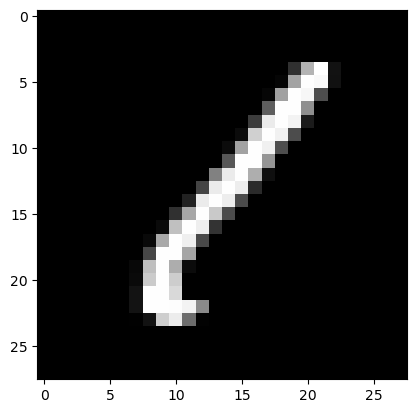

In [57]:
sample = xb[0]
label = yb[0].item()
print("sample label", label)
plt.imshow(sample.view(28, 28), cmap="gray")
plt.show()

---

### Create a basic MLP

In [58]:
class MLP(nn.Module):
    def __init__(self, n_dims: List[int], dropout: float = 0.5, device: Union[str, torch.device] = None):
        super().__init__()
        self.n_dims = n_dims
        self.layers = nn.ModuleList([
            nn.Linear(in_dim, out_dim) for in_dim, out_dim in zip(n_dims, n_dims[1:])
        ])
        self.dropout = nn.Dropout(dropout)
        
        if device:
            self.device = torch.device(device)
            self.to(self.device)
        else:
            self.device = None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:
            x = x.unsqueeze(0)   # add batch dimension of 1 to front
        x = x.view(-1, 28 * 28)  # (batch_size, 28*28)
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
            x = self.dropout(x)
        return self.layers[-1](x)

    def to(self, device: Union[str, torch.device]):
        self.device = torch.device(device)
        return super().to(self.device)

---

### Let's explicitly write out the loss functions and softmax for practice

First to prevent overflow errors in our softmax, we can exploit the property that adding a constant to the argument doesn't change the answer

$$
\text{softmax}(z_i + c) = \frac{\exp(z_i + c)}{\sum_j \exp(z_j + c)} = \frac{\exp(c)\exp(z_i)}{\exp(c)\sum_j \exp(z_j)} = \frac{\exp(z_i)}{\sum_j \exp(z_j)}
$$

So we can subtract the maximum value of the logits from the softmax argument to bound the logits and subsequent exponentials 

$$
\vec{z} \leftarrow \vec{z} - \max(\vec{z}) \quad \Rightarrow \quad z_i \in (-\infty, 0] \quad \Rightarrow \quad \exp(z_i) \in (0, 1]
$$

We also want to add in a temperature parameter in order to control the smoothness of the resulting distribution

$$
\text{softmax}(z_i / T) = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)}
$$

Higher temperatures will tend to smooth out the distribution, increasing entropy as it moves towards being a uniform distribution, while lower temperatures will make the distribution more peaky, decreasing entropy and making the model more confident in its predictions.



In [95]:
def softmax(logits: torch.Tensor, T: float = 1.) -> torch.Tensor:
    """Assumes that logits has shape (batch_size, n_dim)"""
    if logits.dim() == 1:
        logits = logits.unsqueeze(0) # add batch dimension of 1 to front
    # (batch_size, n_dim) -- subtract along each row / sample, dim=1
    # keepdim to preserve the shape after the max operation
    # use .values to extract the tensor from the torch.return_types.max class
    logits = logits - torch.max(logits, dim=1, keepdim=True).values 
    exp_logits = torch.exp(logits / T)
    return  exp_logits / exp_logits.sum(dim=1, keepdim=True)

Note: I guess I could've included a `dim` parameter like the [official torch version](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html)... oh well. Also checkout [log_softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html) which is more numerically stable because it removes the main division operation.

I actually just found a tiny-fied version in numpy [here](https://github.com/mkieffer1107/controls_challenge/blob/master/tinyphysics.py#L74) by comma ai, which I'll include below with a temperature arg.

In [60]:
def tiny_softmax(x: torch.Tensor, T: float = 1., dim: int = -1):
    e_x = torch.exp((x - torch.max(x, dim=dim, keepdim=True).values) / T)
    return e_x / torch.sum(e_x, dim=dim, keepdim=True)

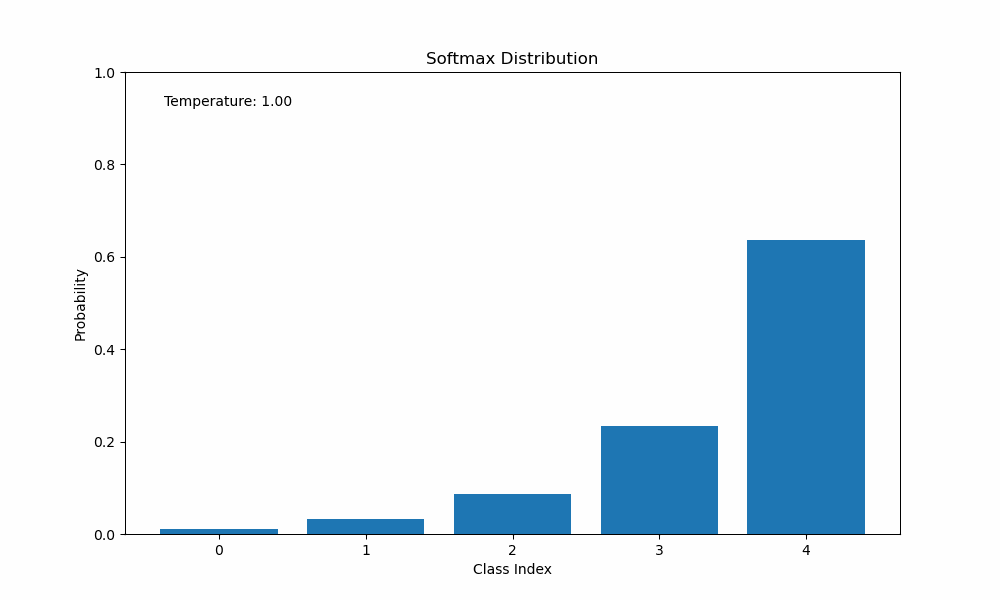

In [98]:
from IPython.display import Image

demo_logits = torch.tensor([[1, 2, 3, 4, 5]])

# set up plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(5), np.zeros(5))
ax.set_xlabel("Class Index")
ax.set_ylabel("Probability")
ax.set_title("Softmax Distribution")
ax.set_ylim(0, 1) # probs between 0 and 1
temp_text = ax.text(0.05, 0.95, "", transform=ax.transAxes, ha="left", va="top")

def update(frame):
    temperature = 1 + frame * 0.1  
    softmax_dist = softmax(demo_logits, temperature).squeeze().numpy()
    
    for bar, height in zip(bars, softmax_dist):
        bar.set_height(height)
    
    temp_text.set_text(f"Temperature: {temperature:.2f}")
    
    return bars + (temp_text,)

# save vid and close render plot
anim = FuncAnimation(fig, update, frames=100, interval=50, blit=True)
anim.save("softmax.gif", writer='pillow')
plt.close()

Image(filename="softmax.gif")
# HTML(anim.to_jshtml())

For our cross entropy, we need to implement

$$
H(\vec{p}, \vec{q}) = - \sum_{i=1}^d p_i \log q_i \quad \text{or} \quad H(\vec{y}, \hat{\vec{y}}) = - \sum_{i=1}^d y_i \log \hat{y}_i
$$

where $d$ is the number of classes, $p_i$ ($\hat{y}_i$) is the target probability for class $i$, and $q_i$ ($y_i$) is the corresponding model prediction for class $i$ (after softmax, so probs) for a single sample. We need to add a small constant to $q_i$ to prevent underflows as $\ln0 \rightarrow -\infty$.

In fact, we actually should write this out as a proper loss function over all the samples $N$ in the batch to sample the gradient stabilize the training

$$
\mathcal{L}_{\text{cross-entropy}} = L(\vec{p}, \vec{q}) = - \frac{1}{N}\sum_{n=1}^N \sum_{i=1}^d p_{ni} \log q_{ni}
$$

Importantly, it needs to be able to handle the case when the target is a single hard label $\vec{p} = p_i \in \mathbb{R}$, and when it is a soft distribution $\vec{p} \in \mathbb{R}^{d}$.

In [62]:
def to_onehot(y: Union[int, torch.Tensor], num_classes: int) -> torch.Tensor:
    """Creates a one-hot encoded vector with bit flipped at index given by y"""
    # source: https://github.com/rasbt/stat479-deep-learning-ss19/blob/master/L08_logistic/code/cross-entropy-pytorch.ipynb
    y_onehot = torch.zeros(y.size(0), num_classes, device=y.device)
    y_onehot.scatter_(1, y.view(-1, 1).long(), 1).float()
    return y_onehot


def cross_entropy_loss(probs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """Assume probs has shape (batch_size, n_dim) and targets has shape (batch_size) or (batch_size, n_dim)"""
    if probs.dim() == 4:
        # flatten the predictions (batch_size, 1, 28, 28) -> (batch_size, 784)
        probs = probs.view(probs.size(0), -1)

    # for hard labels create one-hot encodings over each sample
    if targets.dim() == 1:
        targets = to_onehot(targets, probs.shape[-1])

    # sum the rows to ensure that probs is a valid prob. dist.
    if not torch.allclose(torch.sum(probs, dim=1), torch.ones(probs.shape[0], device=probs.device)):
        probs = softmax(probs)

    # compute the cross-entropy loss (mean over cross-entropy terms)
    log_probs = torch.log(probs + 1e-8)
    return -torch.sum(targets * log_probs, dim=1).mean()

In [63]:
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

---

## Create the training functions

In [64]:
def evaluate(
        model: nn.Module, 
        criterion: Callable, 
        train_data: DataLoader,
        eval_data: DataLoader,
        T: float = 1
    ) -> Tuple[float, float]:
    """Evaluate the model based on some criterion! Should use T=1 during inference."""
    
    def compute_metrics(data_loader: DataLoader) -> Tuple[float, float]:
        """Prettier & more pythonic to put this in here than to have another huge param list"""
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in tqdm(data_loader, desc="Evaluating"):
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                probs = softmax(logits, T)
                loss = criterion(probs, yb)
                running_loss += loss.item()
                
                # get the class indices with the highest prob for each sample
                preds = torch.max(probs, 1).indices # same shape as the labels, yb
                total += yb.size(0)
                correct += (preds == yb).sum().item()
        avg_loss = running_loss / len(data_loader)
        accuracy = correct / total
        return avg_loss, accuracy

    train_loss, train_accuracy = compute_metrics(train_data)
    eval_loss, eval_accuracy = compute_metrics(eval_data)
    
    return train_accuracy, eval_accuracy

In [65]:
def train(
        model: nn.Module, 
        opt: torch.optim.Optimizer,
        num_iters: int, 
        criterion: callable, 
        T: float,
        train_data: DataLoader,
        eval_data: DataLoader
    ):
    """Train the model!"""
    for epoch in range(num_iters):
        model.train()
        running_loss = 0.0
        for xb, yb in tqdm(train_data, desc=f"Training Epoch {epoch+1}/{num_iters}", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            probs = softmax(logits, T=T)
            loss = criterion(probs, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_data)
        train_accuracy, test_accuracy = evaluate(model, criterion, train_data, eval_data, T=1) # use T=1 for inference
        print(f'Epoch {epoch+1}/{num_iters}, Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

We'll introduce a new loss function for distillation. Previously, we used hard cross-entropy loss, meaning that class membership was absolute. This time, however, we will incorporate soft membership. In particular, the loss function will a linear combination between the soft and hard loss terms


$$
\mathcal{L}_{\text{distill}} = \alpha \cdot \mathcal{L}_\text{soft}(T=T_\text{teacher}) + (1 - \alpha) \cdot \mathcal{L}_\text{hard}(T=1) =  - \frac{1}{N}\sum_{n=1}^N \left[ \alpha \cdot T_\text{teacher}^2 \cdot \sum_{i=1}^d p_{ni}^\text{soft} \log q_{ni} + (1 - \alpha) \cdot \sum_{i=1}^d p_{ni}^\text{hard} \log q_{ni} \right]
$$

where $\alpha$ is a weight hyperparameter, $T_\text{teacher}$ is the temperature used to train the teacher model (set to $1$ during inference and for hard target cross-entropy for student training), $N$ is the number of samples in the batch, $q_{ni}$ is the student model prediction for class $i$, $p_{ni}^\text{hard}$ is the one-hot encoded hard membership label for class $i$ (can omit right term if ground truth does not exit), and $p_{ni}^\text{soft}$ is the teacher model prediction for class $i$ that we use as soft membership labels. Notice that the hard loss term is just the ordinary cross-entropy loss as we defined it above for the student model with a prefactor. 

> TODO:
We add a factor of $T^2$ to the front of the soft labels because ...

> TODO:
also maybe here mention that how if we use the raw prob predictions, then most will be zero, so these loss contributions will go to zero. by raising T, we smooth out the distribution and these terems can contribute ...

In [66]:
def distillation_loss(
        student_logits: torch.Tensor, 
        teacher_logits: torch.Tensor, 
        T: float,
        alpha: float,
        hard_targets: torch.Tensor, 
    ) -> torch.Tensor:
    """
    Distillation loss function. The soft loss term uses the
    teacher T during the softmax since its logits come from
    the teacher, but the hard loss term uses T=1 for the
    softmax because it use one-hot encoded labels.
    """
    soft_targets = softmax(teacher_logits, T=T)  # teacher output probs used as soft targets
    student_probs = softmax(student_logits, T=1) # get the student output probs 
    soft_loss = T**2 * cross_entropy_loss(student_probs, soft_targets) # use teacher temp for soft loss
    hard_loss = cross_entropy_loss(student_probs, hard_targets) # student model loss with one-hot encoded labels
    return alpha * soft_loss + (1 - alpha) * hard_loss

In [67]:
def distill_eval(
        teacher: nn.Module, 
        student: nn.Module, 
        criterion: Callable, 
        alpha: float,
        train_data: DataLoader,
        eval_data: DataLoader,
        T: float = 1, 
    ) -> Tuple[float, float]:
    """Evaluate the model based on some criterion! Should use T=1 during inference."""
    
    def compute_metrics(data_loader: DataLoader) -> Tuple[float, float]:
        """Prettier & more pythonic to put this in here than to have another huge param list"""
        teacher.eval()
        student.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in tqdm(data_loader, desc="Evaluating"):
                xb, yb = xb.to(device), yb.to(device)
                teacher_logits = teacher(xb)
                student_logits = student(xb)
                loss = criterion(student_logits, teacher_logits, T, alpha, yb)
                running_loss += loss.item()

                # figure out how accurate the student model is  
                # get the class indices with the highest prob for each sample
                student_probs = softmax(student_logits, T)
                preds = torch.max(student_probs, 1).indices # same shape as the labels, yb
                total += yb.size(0)
                correct += (preds == yb).sum().item()
        avg_loss = running_loss / len(data_loader)
        accuracy = correct / total
        return avg_loss, accuracy

    train_loss, train_accuracy = compute_metrics(train_data)
    eval_loss, eval_accuracy = compute_metrics(eval_data)
    
    return train_accuracy, eval_accuracy


In [68]:
def distill(
        teacher: nn.Module,
        student: nn.Module,
        student_opt: torch.optim.Optimizer,
        teacher_temp: float,
        alpha: float,
        num_iters: int,
        criterion: Callable,
        train_data: DataLoader,
        eval_data: DataLoader
    ):
    """
    Train a student model using knowledge distillation 
    with a pretrained teacher model and teacher_temp. Importantly,
    the hard target cross-entropy uses T=1, while the soft
    target cross-entropy uses T=teacher_temp since it uses teacher 
    probabilities instead of one-hot encodings.
    """
    teacher.eval()
    for epoch in range(num_iters):
        student.train()
        running_loss = 0.0

        for xb, yb in tqdm(train_data, desc=f"Training Epoch {epoch+1}/{num_iters}", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            teacher_logits = teacher(xb)
            student_logits = student(xb)
            loss = criterion(student_logits, teacher_logits, teacher_temp, alpha, yb)
            loss.backward()
            student_opt.step()
            student_opt.zero_grad()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_data)
        eval_loss, eval_accuracy = distill_eval(teacher, student, criterion, alpha, train_data, eval_data, T=1) # use T=1 for inference
        print(f"Epoch {epoch+1}/{num_iters}, Loss: {avg_loss:.4f}, Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")

---

# 2. Train a large teacher model

---

We'll use this large model to distill knowledge to our student models in the next two tasks.

In [69]:
teacher_net = MLP([28**2, 1200, 1200, 10], device=device)
print(f"Teacher Net: {count_parameters(teacher_net)} parameters")

Teacher Net: 2395210 parameters


In [70]:
teacher_loss = cross_entropy_loss
teacher_opt = torch.optim.Adam(teacher_net.parameters(), lr=3e-4)
teacher_iters = 10
teacher_temp = 2

In [71]:
train(
    model=teacher_net, 
    opt=teacher_opt, 
    num_iters=teacher_iters, 
    criterion=teacher_loss, 
    T=teacher_temp,
    train_data=train_loader,
    eval_data=test_loader
)

Evaluating: 100%|██████████| 157/157 [00:00<00:00, 211.16it/s]


Epoch 1/10, Train Loss: 0.3149, Train Accuracy: 0.9571, Test Accuracy: 0.9557


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 172.13it/s]


Epoch 2/10, Train Loss: 0.1370, Train Accuracy: 0.9779, Test Accuracy: 0.9721


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 189.13it/s]


Epoch 3/10, Train Loss: 0.1018, Train Accuracy: 0.9825, Test Accuracy: 0.9763


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 197.26it/s]


Epoch 4/10, Train Loss: 0.0829, Train Accuracy: 0.9868, Test Accuracy: 0.9784


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 212.75it/s]


Epoch 5/10, Train Loss: 0.0749, Train Accuracy: 0.9876, Test Accuracy: 0.9780


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 214.25it/s]


Epoch 6/10, Train Loss: 0.0633, Train Accuracy: 0.9913, Test Accuracy: 0.9823


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 202.50it/s]


Epoch 7/10, Train Loss: 0.0577, Train Accuracy: 0.9926, Test Accuracy: 0.9820


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 217.96it/s]


Epoch 8/10, Train Loss: 0.0531, Train Accuracy: 0.9937, Test Accuracy: 0.9820


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 195.37it/s]


Epoch 9/10, Train Loss: 0.0488, Train Accuracy: 0.9945, Test Accuracy: 0.9829


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 214.58it/s]

Epoch 10/10, Train Loss: 0.0438, Train Accuracy: 0.9950, Test Accuracy: 0.9836


---

# 3. Train a large model on a subset of the data

---

> TODO:
This time we'll ...

### Create the reduced training set

In [72]:
# partition the train set
percentage = 3
train_size = int(percentage/100 * len(train_ds))
remaining_size = len(train_ds) - train_size
train_subset_ds, _ = random_split(train_ds, [train_size, remaining_size])
train_subset_loader = DataLoader(dataset=train_subset_ds, batch_size=64, shuffle=True)

print(f"training on {percentage}% of the training set")
print("initial training set size", len(train_ds))
print("reduced training set size", len(train_subset_ds))
print("test set size", len(test_ds))

training on 3% of the training set
initial training set size 60000
reduced training set size 1800
test set size 10000


### Create the models

We will create two new models:

1) `student_net`: large model taught by teacher

2)  `homeschool_net`: large model that learns on its own

In [73]:
# student_net = MLP(teacher_net.n_dims, device=device)
# homeschool_net = MLP(teacher_net.n_dims, device=device)
student_net = MLP([28**2, 800, 800, 10], dropout=0., device=device)
homeschool_net = MLP([28**2, 800, 800, 10], dropout=0., device=device)

print(f"Teacher Net: {count_parameters(teacher_net)} parameters")
print(f"Student Net: {count_parameters(student_net)} parameters")
print(f"Homeschool Net: {count_parameters(homeschool_net)} parameters")

Teacher Net: 2395210 parameters
Student Net: 1276810 parameters
Homeschool Net: 1276810 parameters


### Train the homeschool model from scratch

In [74]:
homeschool_loss = cross_entropy_loss
homeschool_opt = torch.optim.Adam(homeschool_net.parameters(), lr=3e-4)
homeschool_iters = 10
homeschool_temp = 1

In [75]:
train(
    model=homeschool_net, 
    opt=homeschool_opt, 
    num_iters=homeschool_iters, 
    criterion=homeschool_loss, 
    T=homeschool_temp,
    train_data=train_subset_loader,
    eval_data=test_loader
)

Evaluating: 100%|██████████| 157/157 [00:00<00:00, 210.78it/s]


Epoch 1/10, Train Loss: 1.2393, Train Accuracy: 0.8556, Test Accuracy: 0.8397


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 189.14it/s]


Epoch 2/10, Train Loss: 0.4597, Train Accuracy: 0.9133, Test Accuracy: 0.8839


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 203.72it/s]


Epoch 3/10, Train Loss: 0.3292, Train Accuracy: 0.9267, Test Accuracy: 0.8834


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 223.02it/s]


Epoch 4/10, Train Loss: 0.2248, Train Accuracy: 0.9583, Test Accuracy: 0.9092


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 218.46it/s]


Epoch 5/10, Train Loss: 0.2032, Train Accuracy: 0.9550, Test Accuracy: 0.8993


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 208.58it/s]


Epoch 6/10, Train Loss: 0.1665, Train Accuracy: 0.9700, Test Accuracy: 0.9056


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 207.84it/s]


Epoch 7/10, Train Loss: 0.1247, Train Accuracy: 0.9817, Test Accuracy: 0.9149


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 214.94it/s]


Epoch 8/10, Train Loss: 0.0892, Train Accuracy: 0.9894, Test Accuracy: 0.9182


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 214.11it/s]


Epoch 9/10, Train Loss: 0.0660, Train Accuracy: 0.9928, Test Accuracy: 0.9148


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 207.83it/s]

Epoch 10/10, Train Loss: 0.0596, Train Accuracy: 0.9922, Test Accuracy: 0.9151


### Train the student model with distillation

In [76]:
student_loss = distillation_loss
student_opt = torch.optim.Adam(student_net.parameters(), lr=3e-4)
student_iters = 10
alpha = 0.9

In [77]:
distill(
    teacher=teacher_net, 
    student=student_net, 
    student_opt=student_opt, 
    teacher_temp=teacher_temp,
    alpha=alpha,
    num_iters=student_iters, 
    criterion=student_loss, 
    train_data=train_subset_loader,
    eval_data=test_loader
)

Evaluating: 100%|██████████| 157/157 [00:00<00:00, 169.09it/s]


Epoch 1/10, Loss: 4.5105, Eval Loss: 0.8678, Eval Accuracy: 0.8476


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 169.78it/s]


Epoch 2/10, Loss: 1.4101, Eval Loss: 0.9100, Eval Accuracy: 0.8713


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 169.78it/s]


Epoch 3/10, Loss: 1.0723, Eval Loss: 0.9339, Eval Accuracy: 0.8923


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 175.95it/s]


Epoch 4/10, Loss: 0.8517, Eval Loss: 0.9567, Eval Accuracy: 0.9057


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 174.00it/s]


Epoch 5/10, Loss: 0.6360, Eval Loss: 0.9733, Eval Accuracy: 0.9153


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 169.27it/s]


Epoch 6/10, Loss: 0.4819, Eval Loss: 0.9783, Eval Accuracy: 0.9140


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 173.70it/s]


Epoch 7/10, Loss: 0.3963, Eval Loss: 0.9806, Eval Accuracy: 0.9195


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 174.12it/s]


Epoch 8/10, Loss: 0.2904, Eval Loss: 0.9906, Eval Accuracy: 0.9208


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 167.55it/s]


Epoch 9/10, Loss: 0.2339, Eval Loss: 0.9889, Eval Accuracy: 0.9214


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 165.71it/s]

Epoch 10/10, Loss: 0.2118, Eval Loss: 0.9928, Eval Accuracy: 0.9240


### Compare the performance of the models

> TODO:
We use `T=1` during inference because we want the model's predictions to reflect its true confidence in each class. 
We used a high `T` value during distillation in order to smooth out the distribution to make the teacher model's knowledge more accessible to the student model.


In [78]:
teacher_train_accuracy, teacher_eval_accuracy = evaluate(
    model=teacher_net,
    criterion=teacher_loss,
    T=1,
    train_data=train_subset_loader,
    eval_data=test_loader
)
homeschool_train_accuracy, homeschool_eval_accuracy = evaluate(
    model=homeschool_net,
    criterion=homeschool_loss,
    T=1,
    train_data=train_subset_loader,
    eval_data=test_loader
)
student_train_accuracy, student_eval_accuracy = distill_eval(
    teacher=teacher_net,
    student=student_net,
    criterion=student_loss,
    T=1,
    alpha=alpha,
    train_data=train_subset_loader,
    eval_data=test_loader
)

Evaluating: 100%|██████████| 157/157 [00:00<00:00, 171.50it/s]


In [79]:
header = f"{'Model':<15}{'Train Accuracy':<20}{'Eval Accuracy':<20}{'Percent of Training Set':<15}"
print(header)
print("=" * len(header))
print(f"{'Teacher':<15}{teacher_train_accuracy:<20.4f}{teacher_eval_accuracy:<20.4f}{f'{100}%':<15}")
print(f"{'Homeschool':<15}{homeschool_train_accuracy:<20.4f}{homeschool_eval_accuracy:<20.4f}{f'{percentage}%':<15}")
print(f"{'Student':<15}{student_train_accuracy:<20.4f}{student_eval_accuracy:<20.4f}{f'{percentage}%':<15}")

Model          Train Accuracy      Eval Accuracy       Percent of Training Set
Teacher        0.9956              0.9836              100%           
Homeschool     0.9922              0.9151              3%             
Student        0.9928              0.9240              3%             


---

# 4. Train a small model on a subset of the data omitting a class

---

> TODO:
explanation of this ...

### Remove some classes from the dataset

In [80]:
def withhold_num(dataset: datasets, nums: Union[int, List[int]]) -> Subset:
    """Returns a subset of the data with specified classes removed"""
    if isinstance(nums, int):
        nums = [nums]
    assert all(0 < num < 10 for num in nums)
    indices = [i for i, (_, label) in enumerate(dataset) if label not in nums]
    return Subset(dataset, indices)

We can reuse the old test set, but we need to create a new training set.

In [81]:
nums_to_withhold = [3]
withheld_ds = withhold_num(dataset=train_ds, nums=nums_to_withhold)
withheld_loader = DataLoader(dataset=withheld_ds, batch_size=64, shuffle=True)

print("initial training set size", len(train_ds))
print("classes withheld", nums_to_withhold)
print("reduced training set size", len(withheld_ds))
print("test set size", len(test_ds))

initial training set size 60000
classes withheld [3]
reduced training set size 53869
test set size 10000


We'll also create a function to find how well the model classifies each class.

In [82]:
def percent_correct_per_class(
        model: nn.Module, 
        data_loader: DataLoader, 
        num_classes: int = 10
    ) -> List[float]:
    """Returns """
    model.eval() 
    correct_counts = torch.zeros(num_classes, dtype=torch.int32)
    total_counts = torch.zeros(num_classes, dtype=torch.int32)

    with torch.no_grad():
        for xb, yb in tqdm(data_loader, desc="Calculating correct classifications"):
            xb, yb = xb.to(model.device), yb.to(model.device)
            logits = model(xb)
            preds = torch.max(logits, 1).indices  
            
            for i in range(num_classes):
                total_counts[i] += (yb == i).sum().item()
                correct_counts[i] += ((yb == i) & (preds == i)).sum().item()

    percent_correct = (correct_counts.float() / total_counts.float()) * 100
    
    return percent_correct.tolist()

### Create the models

We will create two new models:

1) `student_net`: small model taught by teacher

2)  `homeschool_net`: small model that learns on its own

In [83]:
student_net = MLP([28**2, 800, 800, 10], dropout=0., device=device)
homeschool_net = MLP([28**2, 800, 800, 10], dropout=0., device=device)

print(f"Teacher Net: {count_parameters(teacher_net)} parameters")
print(f"Student Net: {count_parameters(student_net)} parameters")
print(f"Homeschool Net: {count_parameters(homeschool_net)} parameters")

Teacher Net: 2395210 parameters
Student Net: 1276810 parameters
Homeschool Net: 1276810 parameters


### Train the homeschool model from scratch

In [84]:
homeschool_loss = cross_entropy_loss
homeschool_opt = torch.optim.Adam(homeschool_net.parameters(), lr=3e-4)
homeschool_iters = 10
homeschool_temp = 1

In [85]:
train(
    model=homeschool_net, 
    opt=homeschool_opt, 
    num_iters=homeschool_iters, 
    criterion=homeschool_loss, 
    T=homeschool_temp,
    train_data=withheld_loader,
    eval_data=test_loader
)

Evaluating: 100%|██████████| 157/157 [00:00<00:00, 231.05it/s]


Epoch 1/10, Train Loss: 0.2021, Train Accuracy: 0.9774, Test Accuracy: 0.8720


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 231.56it/s]


Epoch 2/10, Train Loss: 0.0748, Train Accuracy: 0.9838, Test Accuracy: 0.8749


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 230.44it/s]


Epoch 3/10, Train Loss: 0.0483, Train Accuracy: 0.9910, Test Accuracy: 0.8810


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 246.30it/s]


Epoch 4/10, Train Loss: 0.0337, Train Accuracy: 0.9903, Test Accuracy: 0.8792


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 225.08it/s]


Epoch 5/10, Train Loss: 0.0256, Train Accuracy: 0.9932, Test Accuracy: 0.8801


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 202.54it/s]


Epoch 6/10, Train Loss: 0.0210, Train Accuracy: 0.9935, Test Accuracy: 0.8804


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 233.01it/s]


Epoch 7/10, Train Loss: 0.0177, Train Accuracy: 0.9943, Test Accuracy: 0.8819


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 234.33it/s]


Epoch 8/10, Train Loss: 0.0154, Train Accuracy: 0.9973, Test Accuracy: 0.8845


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 213.46it/s]


Epoch 9/10, Train Loss: 0.0147, Train Accuracy: 0.9958, Test Accuracy: 0.8823


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 227.79it/s]

Epoch 10/10, Train Loss: 0.0098, Train Accuracy: 0.9963, Test Accuracy: 0.8814


### Train the student model with distillation

In [86]:
student_loss = distillation_loss
student_opt = torch.optim.Adam(student_net.parameters(), lr=3e-4)
student_iters = 10
alpha = 0.9

In [87]:
distill(
    teacher=teacher_net, 
    student=student_net, 
    student_opt=student_opt, 
    teacher_temp=teacher_temp,
    alpha=alpha,
    num_iters=student_iters, 
    criterion=student_loss, 
    train_data=withheld_loader,
    eval_data=test_loader
)

Evaluating: 100%|██████████| 157/157 [00:00<00:00, 170.39it/s]


Epoch 1/10, Loss: 0.7446, Eval Loss: 0.9749, Eval Accuracy: 0.8738


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 187.07it/s]


Epoch 2/10, Loss: 0.2624, Eval Loss: 0.9856, Eval Accuracy: 0.8803


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 190.42it/s]


Epoch 3/10, Loss: 0.1821, Eval Loss: 0.9882, Eval Accuracy: 0.8891


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 178.23it/s]


Epoch 4/10, Loss: 0.1544, Eval Loss: 0.9915, Eval Accuracy: 0.9014


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 187.98it/s]


Epoch 5/10, Loss: 0.1288, Eval Loss: 0.9919, Eval Accuracy: 0.9029


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 184.26it/s]


Epoch 6/10, Loss: 0.1341, Eval Loss: 0.9924, Eval Accuracy: 0.9051


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 166.29it/s]


Epoch 7/10, Loss: 0.1251, Eval Loss: 0.9919, Eval Accuracy: 0.9376


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 170.01it/s]


Epoch 8/10, Loss: 0.1197, Eval Loss: 0.9949, Eval Accuracy: 0.9073


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 168.74it/s]


Epoch 9/10, Loss: 0.1157, Eval Loss: 0.9942, Eval Accuracy: 0.9162


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 187.13it/s]

Epoch 10/10, Loss: 0.1126, Eval Loss: 0.9949, Eval Accuracy: 0.9053


### Compare the performance of the models

> TODO:
We use `T=1` during inference because we want the model's predictions to reflect its true confidence in each class. 
We used a high `T` value during distillation in order to smooth out the distribution to make the teacher model's knowledge more accessible to the student model.


In [88]:
teacher_train_accuracy, teacher_eval_accuracy = evaluate(
    model=teacher_net,
    criterion=teacher_loss,
    T=1,
    train_data=train_subset_loader,
    eval_data=test_loader
)
homeschool_train_accuracy, homeschool_eval_accuracy = evaluate(
    model=homeschool_net,
    criterion=homeschool_loss,
    T=1,
    train_data=train_subset_loader,
    eval_data=test_loader
)
student_train_accuracy, student_eval_accuracy = distill_eval(
    teacher=teacher_net,
    student=student_net,
    criterion=student_loss,
    T=1,
    alpha=alpha,
    train_data=train_subset_loader,
    eval_data=test_loader
)

Evaluating: 100%|██████████| 157/157 [00:00<00:00, 184.55it/s]


In [89]:
# List of numbers withheld from the training set of homeschool and student net
withheld_str = ', '.join(map(str, nums_to_withhold))  # Convert list to string for display

# Print the results in a nicely formatted table
header = f"{'Model':<15}{'Train Accuracy':<20}{'Eval Accuracy':<20}{'Withheld Classes':<20}"
print(header)
print("=" * len(header))
print(f"{'Teacher':<15}{teacher_train_accuracy:<20.4f}{teacher_eval_accuracy:<20.4f}{'None':<20}")
print(f"{'Homeschool':<15}{homeschool_train_accuracy:<20.4f}{homeschool_eval_accuracy:<20.4f}{withheld_str:<20}")
print(f"{'Student':<15}{student_train_accuracy:<20.4f}{student_eval_accuracy:<20.4f}{withheld_str:<20}")


Model          Train Accuracy      Eval Accuracy       Withheld Classes    
Teacher        0.9956              0.9836              None                
Homeschool     0.8928              0.8814              3                   
Student        0.9167              0.9053              3                   


In [93]:
# Calculate correct classification percentages for each model
teacher_correct = torch.Tensor(percent_correct_per_class(teacher_net, test_loader, 10))
homeschool_correct = torch.Tensor(percent_correct_per_class(homeschool_net, test_loader, 10))
student_correct = torch.Tensor(percent_correct_per_class(student_net, test_loader, 10))

# Define the classes that were withheld during training
nums_to_withhold = [3, 5, 7]

# Print the results in a nicely formatted table with a note for withheld classes
header = f"{'Class':<10}{'Teacher Net':<15}{'Homeschool Net':<20}{'Student Net':<15}{'Withheld':<10}"
print(header)
print("=" * len(header))

for i in range(10):
    withheld_note = "Yes" if i in nums_to_withhold else "No"
    print(f"{i:<10}{teacher_correct[i]:<15.2f}{homeschool_correct[i]:<20.2f}{student_correct[i]:<15.2f}{withheld_note:<10}")


Calculating correct classifications: 100%|██████████| 157/157 [00:00<00:00, 222.15it/s]

Class     Teacher Net    Homeschool Net      Student Net    Withheld  
0         99.18          98.98               99.29          No        
1         99.03          99.38               98.85          No        
2         98.45          98.35               98.06          No        
3         98.02          0.00                21.29          Yes       
4         98.78          98.47               98.27          No        
5         97.98          98.99               98.54          Yes       
6         98.43          97.29               98.33          No        
7         98.74          97.47               97.86          Yes       
8         97.64          95.38               97.84          No        
9         97.22          97.92               97.72          No        


---

# 5 Next Steps

---

We're done! This [tutorial](https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html) on the CIFAR dataset applies knowledge distillation to hidden layers of the network.